## How to Develop Multi-Step LSTM Time Series Forecasting Models for Power Usage
https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

First, we must update the preparation of the training data to include all of the eight features, not just the one total daily power consumed. It requires a single line change: append(data[in_start:in_end, :])

In [1]:
# univariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

Using TensorFlow backend.


In [2]:
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])


In [3]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011


In [4]:
dataset.values.shape

(1442, 8)

In [5]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

In [6]:
train, test = split_dataset(dataset.values)

In [7]:
train.shape

(159, 7, 8)

In [8]:
test.shape

(46, 7, 8)

In [10]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [11]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [9]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [12]:
n_input=14

In [13]:
train_x, train_y = to_supervised(train, n_input)

In [14]:
train_x.shape

(1093, 14, 8)

In [15]:
train_y.shape

(1093, 7)

In [16]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 20, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model


In [17]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [18]:
history = [x for x in train]

In [19]:
len(history)

159

In [20]:
history[1]

array([[2.55001200e+03, 1.49900000e+02, 3.48029910e+05, 1.10022000e+04,
        1.70300000e+03, 5.08200000e+03, 6.89100000e+03, 2.88242000e+04],
       [2.74312000e+03, 2.40280000e+02, 3.50495900e+05, 1.14502000e+04,
        6.62000000e+03, 1.96200000e+03, 5.79500000e+03, 3.13416666e+04],
       [3.93411000e+03, 1.65102000e+02, 3.47940630e+05, 1.63410000e+04,
        1.08600000e+03, 2.53300000e+03, 1.49790000e+04, 4.69705001e+04],
       [1.52876000e+03, 1.78902000e+02, 3.51025000e+05, 6.50520000e+03,
        0.00000000e+00, 3.14000000e+02, 6.97600000e+03, 1.81893333e+04],
       [2.07263800e+03, 2.08876000e+02, 3.50306400e+05, 8.76420000e+03,
        2.20700000e+03, 4.41900000e+03, 9.17600000e+03, 1.87419666e+04],
       [3.17439200e+03, 1.96394000e+02, 3.46854680e+05, 1.33508000e+04,
        1.25200000e+03, 5.16200000e+03, 1.13290000e+04, 3.51635333e+04],
       [2.79610800e+03, 3.12142000e+02, 3.46377150e+05, 1.19526000e+04,
        3.07200000e+03, 7.89300000e+03, 1.25160000e+04, 2.

In [22]:
data = array(history)

In [23]:
data.shape

(159, 7, 8)

In [24]:
type(history)

list

In [25]:
type(train)

numpy.ndarray

In [21]:
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data, change array to a list.
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [22]:
# split into train and test
train, test = split_dataset(dataset.values)

In [23]:
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)

lstm: [457.989] 443.7, 402.3, 391.5, 479.4, 456.4, 392.2, 603.6


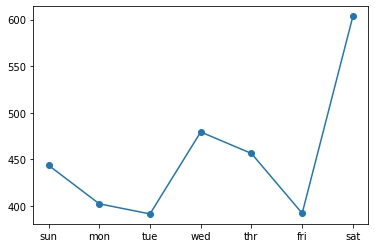

In [24]:
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()